# Calculate Atmospheric attenuation according to ITU-R P.676 (10)

## License

```
Calculate Atmospheric attenuation according to ITU-R P.676 (10).
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as apu
from pycraf import atm
from pycraf import conversions as cnv

## Preparatory: Atmospheric profiles according to ITU R-P.835 (5)

To calculate atmospheric attenuation (by oxygen and water), it is necessary to know the pressure, temperature and water content of the atmospheric layer(s) along the propagating path. For Earth-space paths this means that the height profiles of the three quantities must be known. Furthermore, for accurate raytracing, refraction must be dealt with. Usually this is done by assuming a hard boundary between two adjacent layers having different physical conditions and applying Snells law. The refractive index can be derived from temperature, total pressure and water pressure (which is usually a small fraction of total pressure, because water has much smaller scale heights).

From ITU-R P.453 (10) various helper functions are derived, to compute refractive index, or water vapor pressure from total pressure and temperature (this assumes thermodynamic equilibrium, which might not be present in certain layers, so be careful).

### Standard profile

The *standard profile* represents a typical height profile as averaged over many different environmental conditions and locations.

#### Example: standard height profile plot

In [3]:
# define height grid
height_grid = np.arange(0, 85, 0.1) * apu.km

# query profile_standard function
(
    temperatures,
    pressures,
    rho_water,
    pressures_water,
    ref_indices,
    humidities_water,
    humidities_ice
    ) = atm.profile_standard(height_grid)

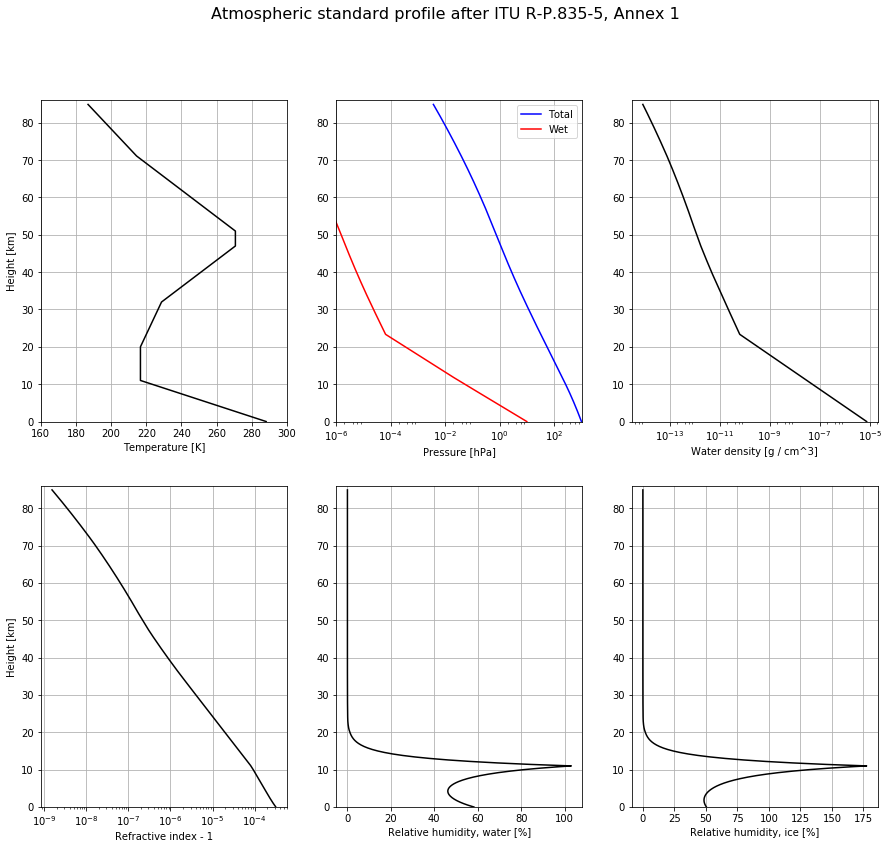

In [4]:
# Plot various quantities
_heights = height_grid.to(apu.km).value

plt.close()
fig = plt.figure(figsize=(15, 13))
axes = [fig.add_subplot(2, 3, i) for i in range(1, 7)]
axes[0].plot(temperatures.to(apu.K).value, _heights, 'k-')
axes[0].set_xlabel('Temperature [K]')
axes[0].set_xlim((160, 300))
axes[1].plot(pressures.to(apu.hPa), _heights, 'b-', label='Total')
axes[1].plot(pressures_water.to(apu.hPa), _heights, 'r-', label='Wet')
axes[1].legend(
    *axes[1].get_legend_handles_labels(),
    loc='upper right', fontsize=10
    )
axes[1].set_xlabel('Pressure [hPa]')
axes[1].semilogx()
axes[1].set_xlim((1.e-6, 1100))
axes[2].plot(rho_water.to(apu.g / apu.cm ** 3).value, _heights, 'k-')
axes[2].set_xlabel('Water density [g / cm^3]')
axes[2].semilogx()
#ax3.set_xlim((1.e-3, 1100))
axes[3].plot(ref_indices.to(cnv.dimless).value - 1., _heights, 'k-')
axes[3].set_xlabel('Refractive index - 1')
axes[3].semilogx()
#ax3.set_xlim((1.e-3, 1100))
axes[4].plot(humidities_water.to(apu.percent).value, _heights, 'k-')
axes[4].set_xlabel('Relative humidity, water [%]')
axes[5].plot(humidities_ice.to(apu.percent).value, _heights, 'k-')
axes[5].set_xlabel('Relative humidity, ice [%]')
for idx, ax in enumerate(axes):
    ax.set_ylim((0, 86))
    if idx % 3 == 0:
        ax.set_ylabel('Height [km]')
    ax.grid()


fig.suptitle('Atmospheric standard profile after ITU R-P.835-5, Annex 1', fontsize=16)
plt.show()

### Specialized profiles

In Annex 2 of ITU R-P.835, five more profiles are defined
- Low latitude, $\vert\varphi\vert < 22^\circ$
- Mid latitude (Summer, Winter), $22^\circ \leq \vert\varphi\vert \leq 45^\circ$
- High latitude (Summer, Winter), $\vert\varphi\vert > 45^\circ$

Like for the standard profile, the python functions return not only temperature, pressure and water vapor density, but some additional quantities needed for atmospheric attenuation calculations.

#### Example: specialized height profile plots

The following example plots various height profile quantities for the five different models. At the moment it remains unclear to me, what to do, if conditions (e.g., as measured from a weather station for the lowest layer) deviate from these average profiles.

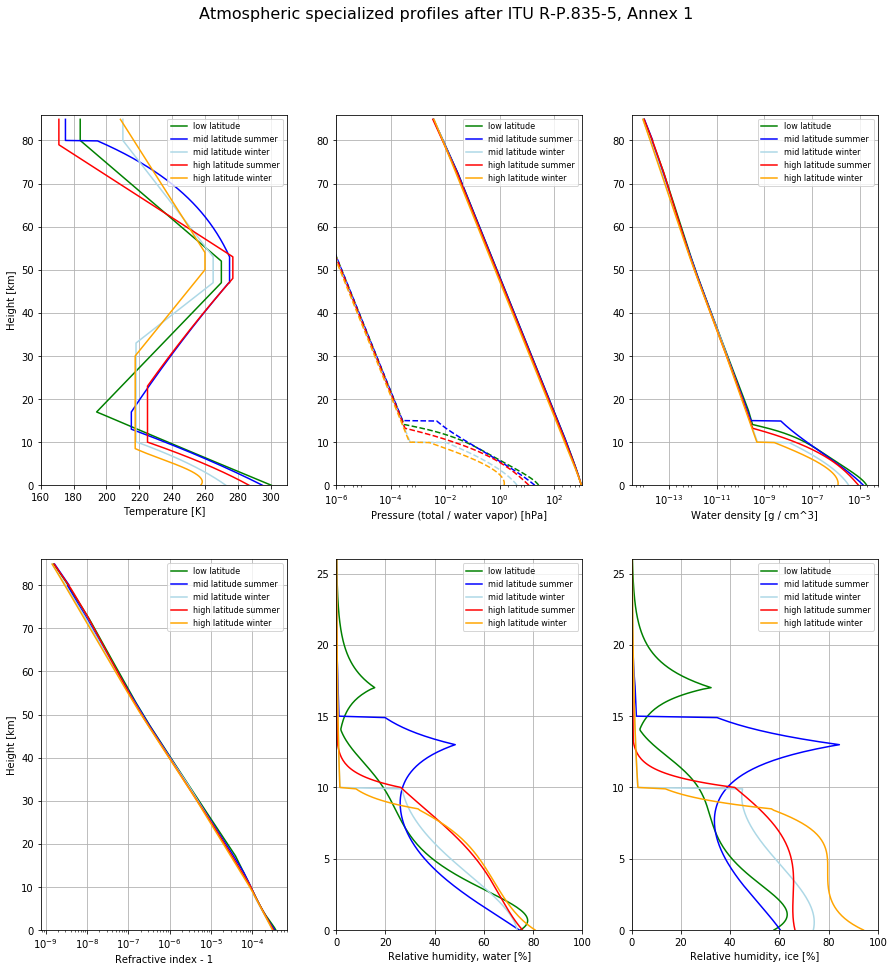

In [5]:
_heights = np.arange(0, 85, 0.1)
height_grid = _heights * apu.km

plt.close()
fig = plt.figure(figsize=(15, 15))
axes = [fig.add_subplot(2, 3, i) for i in range(1, 7)]

for name, func, color in [
        ('low latitude', atm.profile_lowlat, 'g'),
        ('mid latitude summer', atm.profile_midlat_summer, 'b'),
        ('mid latitude winter', atm.profile_midlat_winter, 'lightblue'),
        ('high latitude summer', atm.profile_highlat_summer, 'r'),
        ('high latitude winter', atm.profile_highlat_winter, 'orange'),
        ]:
    (
        temperature,
        pressure,
        rho_water,
        pressure_water,
        ref_index,
        humidity_water,
        humidity_ice
        ) = func(height_grid)

    axes[0].plot(temperature.to(apu.K).value, height_grid, '-', color=color, label=name)
    axes[0].set_xlabel('Temperature [K]')
    axes[1].plot(pressure.to(apu.hPa).value, height_grid, '-', color=color, label=name)
    axes[1].plot(pressure_water.to(apu.hPa).value, height_grid, '--', color=color)  #, label=name
    axes[1].set_xlabel('Pressure (total / water vapor) [hPa]')
    axes[2].plot(rho_water.to(apu.g / apu.cm ** 3).value, height_grid, '-', color=color, label=name)
    axes[2].set_xlabel('Water density [g / cm^3]')
    axes[3].plot(ref_index.to(cnv.dimless).value - 1., height_grid, '-', color=color, label=name)
    axes[3].set_xlabel('Refractive index - 1')
    axes[4].plot(humidity_water.to(apu.percent).value, height_grid, '-', color=color, label=name)
    axes[4].set_xlabel('Relative humidity, water [%]')
    axes[5].plot(humidity_ice.to(apu.percent).value, height_grid, '-', color=color, label=name)
    axes[5].set_xlabel('Relative humidity, ice [%]')
    
axes[0].set_xlim((160, 310))
axes[1].set_xlim((1.e-6, 1100))
axes[4].set_xlim((0, 100))
axes[5].set_xlim((0, 100))

axes[1].semilogx()
axes[2].semilogx()
axes[3].semilogx()

for idx, ax in enumerate(axes):
    ax.legend(*ax.get_legend_handles_labels(), loc='upper right', fontsize=8)
    ax.set_ylim((0, 86))
    if idx % 3 == 0:
        ax.set_ylabel('Height [km]')
    ax.grid()

axes[4].set_ylim((0, 26))
axes[5].set_ylim((0, 26))
fig.suptitle('Atmospheric specialized profiles after ITU R-P.835-5, Annex 1', fontsize=16)
plt.show()

## Atmospheric attenuation: ITU-R P.676 (10) Annex 1

For atmospheric attuation, we first need to solve the special case of a path propagating through one specific layer (having just one set of physical conditions, i.e., one temperature, pressure, etc.). If propagation in a Earth-parallel path is of interest, this already solves the problem. However, for tilted paths of propagation and Earth-Space paths, we need to consider the height profiles shown above and ray-trace through layers of atmospheric conditions.

### Specific attenuation
Attenuation is mainly caused by oxygen and water resonance lines, as well as the Debye-absorption of dry air. The resonance lines below 2 THz were copy-pasted from the recommendation into csv-tables for convenience. The first column is the resonance frequency, the other columns describe the lines (strength, width, etc.). For details, we refer to the recommendation itself.

In [6]:
# this looks like the following (first 5 entries):
print(atm.resonances_oxygen[:50])
print(atm.resonances_water[:5])

[(50.474214, 0.975, 9.651, 6.69, 0.0, 2.566, 6.85)
 (50.987745, 2.529, 8.653, 7.17, 0.0, 2.246, 6.8)
 (51.50336, 6.193, 7.709, 7.64, 0.0, 1.947, 6.729)
 (52.021429, 14.32, 6.819, 8.11, 0.0, 1.667, 6.64)
 (52.542418, 31.24, 5.983, 8.58, 0.0, 1.388, 6.526)
 (53.066934, 64.29, 5.201, 9.06, 0.0, 1.349, 6.206)
 (53.595775, 124.6, 4.474, 9.55, 0.0, 2.227, 5.085)
 (54.130025, 227.3, 3.8, 9.96, 0.0, 3.17, 3.75)
 (54.67118, 389.7, 3.182, 10.37, 0.0, 3.558, 2.654)
 (55.221384, 627.1, 2.618, 10.89, 0.0, 2.56, 2.952)
 (55.783815, 945.3, 2.109, 11.34, 0.0, -1.172, 6.135)
 (56.264774, 543.4, 0.014, 17.03, 0.0, 3.525, -0.978)
 (56.363399, 1331.8, 1.654, 11.89, 0.0, -2.378, 6.547)
 (56.968211, 1746.6, 1.255, 12.23, 0.0, -3.545, 6.451)
 (57.612486, 2120.1, 0.91, 12.62, 0.0, -5.416, 6.056)
 (58.323877, 2363.7, 0.621, 12.95, 0.0, -1.932, 0.436)
 (58.446588, 1442.1, 0.083, 14.91, 0.0, 6.768, -1.273)
 (59.164204, 2379.9, 0.387, 13.53, 0.0, -6.561, 2.309)
 (59.590983, 2090.7, 0.207, 14.08, 0.0, 6.957, -0.77

Both, oxygen and water vapor lines are defined via an amplitude (aka line strength), $S$, their width, $\Delta f$, and profile shape, $F$. For the shape $F$, which depends on $\Delta F$, there is another parameter $\delta$ which is a kind of correction parameter. The function $N_\mathrm{D}^{\prime\prime}$ returns the Debye absorption spectrum. The following Python helper functions implement this.

#### Examples

In [7]:
# Example: Standard atmosphere
_freqs = np.arange(1, 1000, 1)
freq_grid = _freqs * apu.GHz
total_pressure = 1013 * apu.hPa
temperature = 290 * apu.K
rho_water = 7.5 * apu.g / apu.m ** 3

pressure_water = atm.pressure_water_from_rho_water(temperature, rho_water)
pressure_dry = total_pressure - pressure_water

print(
    'Oxygen pressure: {0.value:.2f} {0.unit}, '
    'Water vapor partial pressure: {1.value:.2f} {1.unit}'.format(
        pressure_dry, pressure_water
    ))

atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )

Oxygen pressure: 1002.96 hPa, Water vapor partial pressure: 10.04 hPa


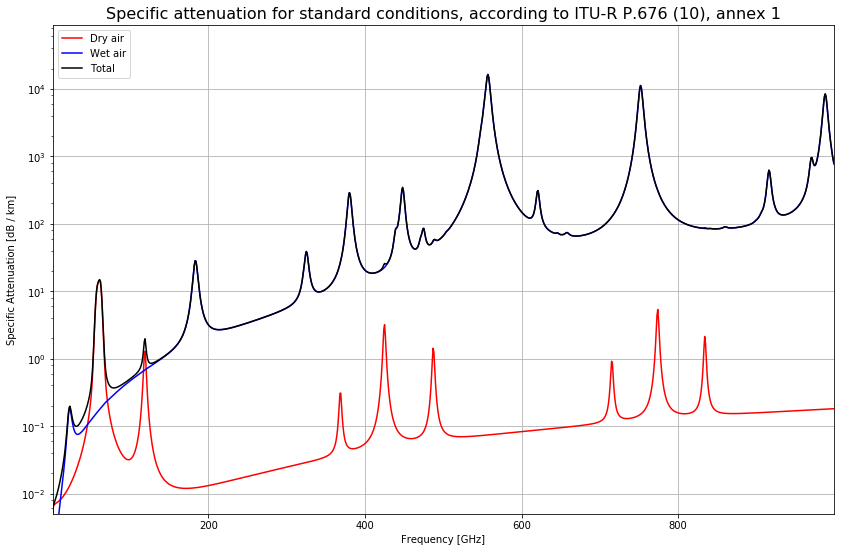

In [8]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / apu.km).value, 'r-', label='Dry air')
plt.plot(_freqs, atten_wet.to(cnv.dB / apu.km).value, 'b-', label='Wet air')
plt.plot(_freqs, (atten_dry + atten_wet).to(cnv.dB / apu.km).value, 'k-', label='Total')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((1, 999))
plt.ylim((5.e-3, 0.9e5))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title(
    'Specific attenuation for standard conditions, according to ITU-R P.676 (10), annex 1',
    fontsize=16
    )
plt.show()

At large heights (small pressure) the oxygen resonances are "resolved":

In [9]:
pressure_dry, pressure_water

(<Quantity 1002.9630826026765 hPa>, <Quantity 10.036917397323489 hPa>)

In [10]:
# Example: Large height
_freqs = np.arange(50, 70, 0.01)
freq_grid = _freqs * apu.GHz
height = 20. * apu.km
profile_at_height = atm.profile_highlat_summer(height)
temperature, total_pressure, rho_water, pressure_water, _, _, _ = profile_at_height
temperature = temperature.squeeze()
total_pressure = total_pressure.squeeze()
pressure_water = pressure_water.squeeze()
pressure_dry = total_pressure - pressure_water

print(
    'Oxygen pressure: {0.value:.2f} {0.unit}, '
    'Water vapor partial pressure: {1.value:.2f} {1.unit}'.format(
        pressure_dry, pressure_water
    ))

atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )

Oxygen pressure: 61.99 hPa, Water vapor partial pressure: 0.00 hPa


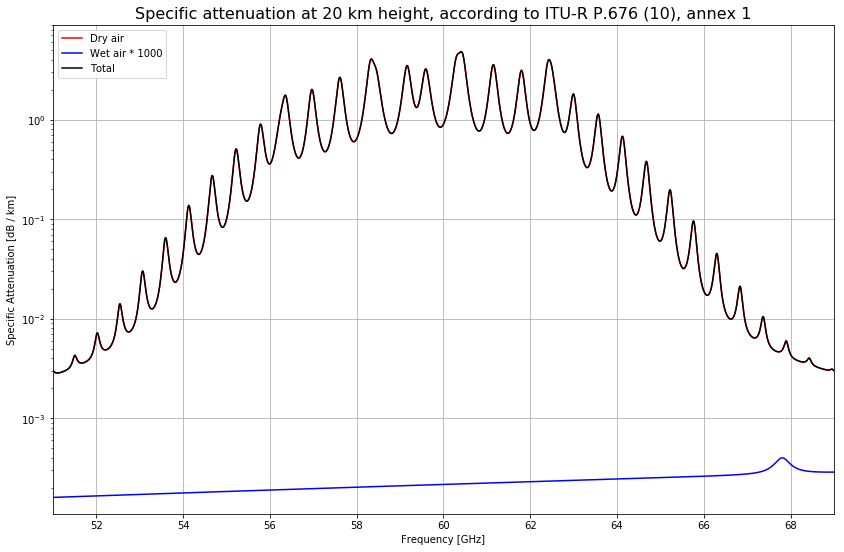

In [11]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / apu.km).value, 'r-', label='Dry air')
plt.plot(_freqs, atten_wet.to(cnv.dB / apu.km).value * 1000, 'b-', label='Wet air * 1000')
plt.plot(_freqs, (atten_dry + atten_wet).to(cnv.dB / apu.km).value, 'k-', label='Total')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((51, 69))
plt.ylim((1.1e-4, 9e0))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title(
    'Specific attenuation at 20 km height, according to ITU-R P.676 (10), annex 1',
    fontsize=16
    )
plt.show()

### Path attenuation

Note, to convert between attenuation, $\gamma$, and (zenith!) opacity, $\tau$, use

\begin{eqnarray}
\gamma [\mathrm{dB}] &=& 10\log_{10} \gamma\\
\gamma &=& 10^{\gamma [\mathrm{dB}] / 10}\\
\gamma &=& e^{-\tau\cdot \mathrm{AM}},\qquad \mathrm{AM}=\frac{1}{\sin\delta}\\
\tau &=& -\frac{1}{\mathrm{AM}}\ln\gamma
\end{eqnarray}

#### Terrestrial paths

This assumes that only one atmospheric layer (i.e., a single set of pressures/temperatures) is involved. Total attenuation is simply the product of path length with specific attenuation.

#### Slant paths
Calculate total attenuation for an arbitrary path through Earth's atmosphere by raytracing through multiple atmospheric layers. Note, that we also calculate the equivalent blackbody radiation of the atmosphere. Each layer contributes to Tebb (multiply its temperature with absorption coefficient, $\kappa=1-\gamma$) but attenuates the radiation of all previous layers. Another auxillary quantity that our code provides is the refraction angle, the amount of bending the ray experiences.

The internal helper function '_prepare_path' sets the path of propagation up. It is not exposed via the public API (and as such, you should not rely on it). Here, we just use it to show, how the slant path looks like. This could be used to find correct start elevation angle and maximal path length for a terrestrial path that crosses multiple layers. Plotting an example:

total path length 1: 390.5 km
total path length 2:  59.6 km


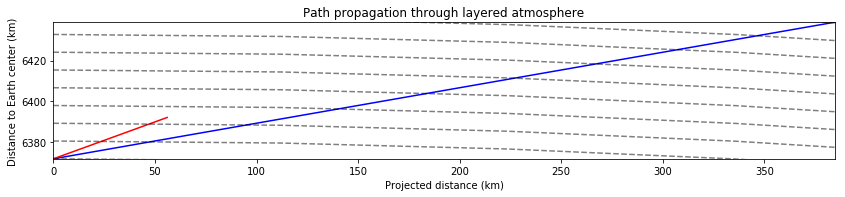

In [12]:
elevation = 10  # deg
obs_alt = 300.  # m
path_params_1, _ = atm.atm._prepare_path(
    elevation, obs_alt, atm.profile_highlat_winter
    )
elevation = 20  # degrees
obs_alt = 300.  # meters
path_params_2, _ = atm.atm._prepare_path(
    elevation, obs_alt, atm.profile_highlat_winter, max_path_length=60.
    )

print('total path length 1: {:5.1f} km'.format(sum(t[3] for t in path_params_1)))
print('total path length 2: {:5.1f} km'.format(sum(t[3] for t in path_params_2)))

radii_1 = np.array([t[4] for t in path_params_1])
angles_1 = np.array([t[6] for t in path_params_1])
radii_2 = np.array([t[4] for t in path_params_2])
angles_2 = np.array([t[6] for t in path_params_2])
layer_angles = np.linspace(0, 2 * np.pi, 360)

x1, y1 = radii_1 * np.sin(angles_1), radii_1 * np.cos(angles_1)
x2, y2 = radii_2 * np.sin(angles_2), radii_2 * np.cos(angles_2)

plt.close()
fig = plt.figure(figsize=(14, 6))
plt.plot(x1, y1, 'b-')
plt.plot(x2, y2, 'r-')
for r in np.linspace(radii_1[0], radii_1[-1], 10):
    plt.plot(r * np.sin(layer_angles), r * np.cos(layer_angles), 'k--', alpha=0.5)

plt.xlim((x1[0], x1[-1]))
plt.ylim((y1[0], y1[-1]))
plt.title('Path propagation through layered atmosphere')
plt.xlabel('Projected distance (km)')
plt.ylabel('Distance to Earth center (km)')
plt.gca().set_aspect('equal')
plt.show()




Now do the path propagation calculations.

Refraction for Winter, Elevation: 90 deg: -0.0 deg arcsec
Refraction for Summer, Elevation: 90 deg: -0.0 deg arcsec
Refraction for Winter, Elevation: 15 deg: -228.6 deg arcsec
Refraction for Summer, Elevation: 15 deg: -237.9 deg arcsec


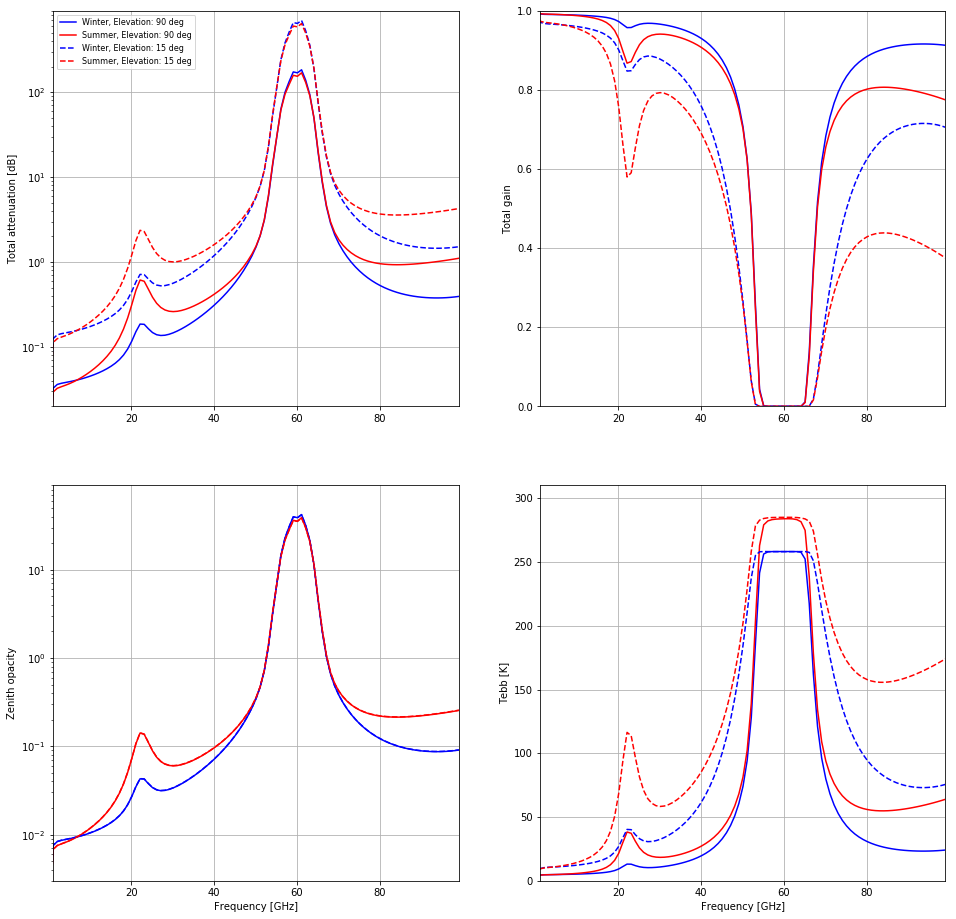

In [13]:
elevation = 5 * apu.deg
obs_alt = 300 * apu.m
_freqs = np.arange(0.1, 100, 1)
freq_grid = _freqs * apu.GHz

cases = [
    # elevation, profile, label, linestyle
    (90 * apu.deg, atm.profile_highlat_winter, 'Winter, Elevation: 90 deg', 'b-'),
    (90 * apu.deg, atm.profile_highlat_summer, 'Summer, Elevation: 90 deg', 'r-'),
    (15 * apu.deg, atm.profile_highlat_winter, 'Winter, Elevation: 15 deg', 'b--'),
    (15 * apu.deg, atm.profile_highlat_summer, 'Summer, Elevation: 15 deg', 'r--'),
    ]

plt.close()
fig = plt.figure(figsize=(16, 16))
axes = [fig.add_subplot(2, 2, i) for i in range(1, 5)]
for elevation, profile, label,linestyle in cases:
    
    total_atten, refraction, tebb = atm.atten_slant_annex1(
        freq_grid, elevation, obs_alt, profile, t_bg=2.73 * apu.K
        )
    opacity = atm.opacity_from_atten(total_atten, elevation)

    print('Refraction for {}: {:.1f} arcsec'.format(label, refraction * 3600))

    axes[0].plot(_freqs, total_atten.to(cnv.dB).value, linestyle, label=label)
    axes[1].plot(_freqs, (-total_atten).to(cnv.dimless).value, linestyle, label=label)
    axes[2].plot(_freqs, opacity.to(cnv.dimless).value, linestyle, label=label)
    axes[3].plot(_freqs, tebb.to(apu.K).value, linestyle, label=label)
    
axes[0].semilogy()
axes[2].semilogy()
axes[0].legend(*axes[0].get_legend_handles_labels(), loc='upper left', fontsize=8)
axes[0].set_ylabel('Total attenuation [dB]')
axes[1].set_ylabel('Total gain')
axes[2].set_ylabel('Zenith opacity')
axes[3].set_ylabel('Tebb [K]')
axes[0].set_ylim((2e-2, 9e2))
axes[1].set_ylim((0, 1))
axes[2].set_ylim((3e-3, 9e1))
axes[3].set_ylim((0, 310))

for idx, ax in enumerate(axes):
    ax.grid()
    ax.set_xlim((1, 99))
    if idx >= 2:
        ax.set_xlabel('Frequency [GHz]')

plt.show()

## Atmospheric attenuation: Annex 2

The numerical routines in Annex 1 are relatively time consuming. For frequencies below 350 GHz, ITU-R P676 (10) therefore provides lower-accuracy but more efficient algorithms that describe the attenuation spectrum via "ad-hoc" functions.

### Specific attenuation

Again, we first need the specific attenuation which describes the attenuation per path length within one fixed atmospheric layer.

#### Example: Comparison Annex 1 vs. Annex 2 for standard atmosphere

In [14]:
# Example: Standard atmosphere
_freqs = np.arange(1, 350, 0.5)
freq_grid = _freqs * apu.GHz
total_pressure = 1013 * apu.hPa
temperature = 290 * apu.K
rho_water = 7.5 * apu.g / apu.m ** 3
pressure_water = atm.pressure_water_from_rho_water(temperature, rho_water)
pressure_dry = total_pressure - pressure_water
print(
    'Oxygen pressure: {0.value:.2f} {0.unit}, '
    'Water vapor partial pressure: {1.value:.2f} {1.unit}'.format(
        pressure_dry, pressure_water
    ))

atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )
simple_atten_dry, simple_atten_wet = atm.atten_specific_annex2(
    freq_grid, total_pressure, rho_water, temperature
    )

atten_tot = atten_dry + atten_wet
simple_atten_tot = simple_atten_dry + simple_atten_wet

Oxygen pressure: 1002.96 hPa, Water vapor partial pressure: 10.04 hPa


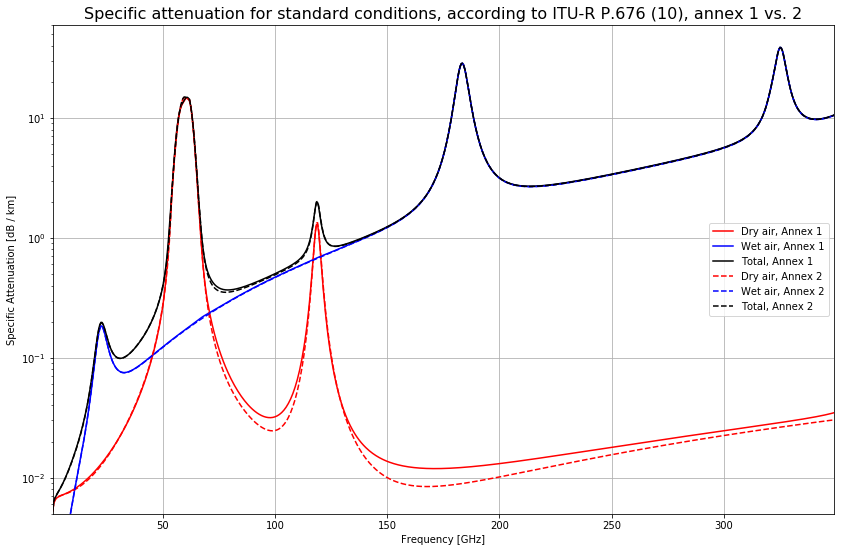

In [15]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / apu.km).value, 'r-', label='Dry air, Annex 1')
plt.plot(_freqs, atten_wet.to(cnv.dB / apu.km).value, 'b-', label='Wet air, Annex 1')
plt.plot(_freqs, atten_tot.to(cnv.dB / apu.km).value, 'k-', label='Total, Annex 1')
plt.plot(_freqs, simple_atten_dry.to(cnv.dB / apu.km).value, 'r--', label='Dry air, Annex 2')
plt.plot(_freqs, simple_atten_wet.to(cnv.dB / apu.km).value, 'b--', label='Wet air, Annex 2')
plt.plot(_freqs, simple_atten_tot.to(cnv.dB / apu.km).value, 'k--', label='Total, Annex 2')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((1, 349))
plt.ylim((5.e-3, 6e1))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='center right')
plt.title(
    'Specific attenuation for standard conditions, according to ITU-R P.676 (10), annex 1 vs. 2',
    fontsize=16
    )
plt.show()

### Path attenuation
#### Terrestrial paths

Use same formula as for Annex 1.

#### Slant paths

For the simplified algorithm, no raytracing is performed. Instead, one works with an effective atmosphere, consisting of one hypothetical layer. For this, ITU-R P.676-10 provides formulae to calculate the effective path length (for dry and wet air), the so-called equivalent height, that leads to the correct total attenuation if the specific attenuation of the ground is plugged-in.

#### Example: equivalent heights of standard atmosphere

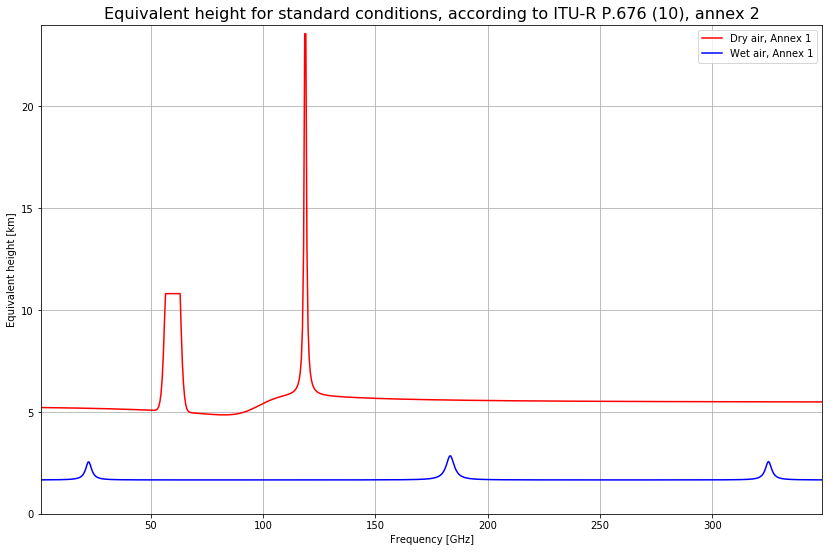

In [16]:
# Example: Standard atmosphere
_freqs = np.arange(1, 350, 0.5)
freq_grid = _freqs * apu.GHz
total_pressure = 1013 * apu.hPa
h_dry = atm.equivalent_height_dry(freq_grid, total_pressure)
h_wet = atm.equivalent_height_wet(freq_grid, total_pressure)

plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, h_dry.to(apu.km).value, 'r-', label='Dry air, Annex 1')
plt.plot(_freqs, h_wet.to(apu.km).value, 'b-', label='Wet air, Annex 1')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Equivalent height [km]')
plt.xlim((1, 349))
plt.ylim((0, 24))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper right')
plt.title(
    'Equivalent height for standard conditions, according to ITU-R P.676 (10), annex 2',
    fontsize=16
    )
plt.show()


With this, the total attenuation is easily calculated, just correct for Air mass (elevation).

#### Example: total path attenuation for standard atmosphere (Annex 1 vs. 2)

In [17]:
# Example 2: Standard atmosphere
_freqs = np.arange(1, 350, 0.5)
freq_grid = _freqs * apu.GHz
elevation = 15. * apu.deg
obs_alt = 300. * apu.m

profile_at_0m = atm.profile_standard(0. * apu.m)
temperature, pressure_total, rho_water, pressure_water, _, _, _ = profile_at_0m

pressure_dry = pressure_total - pressure_water
h_dry = atm.equivalent_height_dry(freq_grid, pressure_dry)
h_wet = atm.equivalent_height_wet(freq_grid, pressure_dry)

simple_atten_dry, simple_atten_wet = atm.atten_specific_annex2(
    freq_grid, total_pressure, rho_water, temperature
    )
simple_atten_tot_slant = atm.atten_slant_annex2(
    simple_atten_dry, simple_atten_wet, h_dry, h_wet, elevation
    )
simple_opacity_tot_slant = atm.opacity_from_atten(simple_atten_tot_slant, elevation)

atten_tot_slant, _, _ = atm.atten_slant_annex1(
    freq_grid, elevation, obs_alt, atm.profile_standard, t_bg=2.73 * apu.K
    )
opacity_tot_slant = atm.opacity_from_atten(atten_tot_slant, elevation)

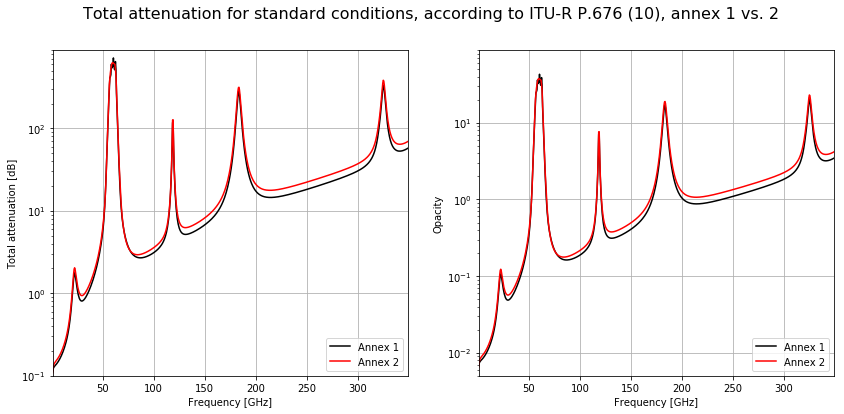

In [18]:
plt.close()
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(_freqs, atten_tot_slant.to(cnv.dB).value, 'k-', label='Annex 1')
ax1.plot(_freqs, simple_atten_tot_slant.to(cnv.dB).value, 'r-', label='Annex 2')
ax2.plot(_freqs, opacity_tot_slant.to(cnv.dimless).value, 'k-', label='Annex 1')
ax2.plot(_freqs, simple_opacity_tot_slant.to(cnv.dimless).value, 'r-', label='Annex 2')
ax1.semilogy()
ax1.set_xlim((1, 349))
ax1.set_ylim((1.e-1, 9.e2))
ax2.semilogy()
ax2.set_xlim((1, 349))
ax2.set_ylim((5.e-3, 9.e1))
ax1.grid()
ax2.grid()
ax1.legend(*ax1.get_legend_handles_labels(), loc='lower right')
ax2.legend(*ax2.get_legend_handles_labels(), loc='lower right')
ax1.set_xlabel('Frequency [GHz]')
ax2.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Total attenuation [dB]')
ax2.set_ylabel('Opacity')
plt.suptitle(
    'Total attenuation for standard conditions, according to ITU-R P.676 (10), annex 1 vs. 2',
    fontsize=16
    )
plt.show()